## Install External Libraries

In [0]:
!pip install PyPortfolioOpt
!pip install yfinance

## Import Dependencies

In [0]:
import matplotlib
import pypfopt
import datetime
import math

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Set Local Variables

In [0]:
risk_free_rate = 0.06501 # Risk-free rate of return, 10Yr Treasury Bond Yield
trading_days = 240 # No of trading days in a year

start_date = datetime.date(2000, 1, 1) # Oldest date to be considered for price analysis
investment_date = datetime.date(2019, 1, 1) # Date when funds are invested 
investment_end = datetime.date(2020, 5, 1) # Date of end of investment period

In [0]:
asset_universe = ['HDFC.BO', 'BAJFINANCE.BO', 'SBIN.BO', 'TITAN.BO', 'HDFCBANK.BO', 
                  'HEROMOTOCO.BO', 'INFY.BO', 'KOTAKBANK.BO', 'ONGC.BO', 'RELIANCE.BO',
                  'TATASTEEL.BO', 'LT.BO', 'M&M.BO', 'HINDUNILVR.BO', 'NESTLEIND.BO',
                  'ASIANPAINT.BO', 'ITC.BO', 'SUNPHARMA.BO', 'ICICIBANK.BO', 'INDUSINDBK.BO',
                  'AXISBANK.BO', 'HCLTECH.BO', 'BHARTIARTL.BO', 'MARUTI.BO','ULTRACEMCO.BO',
                  'TCS.BO', 'NTPC.BO', 'TECHM.BO', 'POWERGRID.BO','BAJAJ-AUTO.BO'
]

### Markowitz

In [0]:
# Download historical closing prices
sensex30_history = yf.download(asset_universe, start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']
sensex_history = yf.download('^BSESN', start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']

[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  1 of 1 completed


In [0]:
# Rename Data Columns
rename_col_dict = dict()
for ticker in sensex30_history.columns:
  rename_col_dict[ticker] = ticker[:-3]

sensex30_history = sensex30_history.rename(columns=rename_col_dict)

In [0]:
# Compute expected returns
sensex30_prices = sensex30_history.loc[start_date:investment_date , :].copy()

# Compute annualised mean daily returns of 30 stocks using data since 2000
mean_daily_returns = sensex30_prices.pct_change().dropna(how="all").mean()

# Annualise mean daily returns via compounding
expected_returns = (1 + mean_daily_returns) ** trading_days - 1
# print(expected_returns*100)

# Compute Covariance Matrix
cov_matrix = pypfopt.risk_models.CovarianceShrinkage(sensex30_prices, frequency=trading_days).ledoit_wolf(shrinkage_target="constant_correlation")

In [0]:
ef = pypfopt.efficient_frontier.EfficientFrontier(expected_returns, cov_matrix)
ef.max_sharpe(risk_free_rate)
mvo_max_sharpe_wts = ef.clean_weights()
# ef.portfolio_performance(verbose=True)

mvo_max_sharpe_nonzero_wts = dict()
for key, val in mvo_max_sharpe_wts.items():
  if val != 0:
    mvo_max_sharpe_nonzero_wts[key] = val

In [0]:
ef = pypfopt.efficient_frontier.EfficientFrontier(expected_returns, cov_matrix)
ef.min_volatility()
mvo_min_volatility_wts = ef.clean_weights()
# ef.portfolio_performance(verbose=True)

mvo_min_volatility_nonzero_wts = dict()
for key, val in mvo_min_volatility_wts.items():
  if val != 0:
    mvo_min_volatility_nonzero_wts[key] = val

### Black-Litterman

In [0]:
# Download historical closing prices
sensex30_history = yf.download(asset_universe, start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']
sensex_history = yf.download('^BSESN', start=start_date, end=investment_end, auto_adjust=True).loc[:, 'Close']

In [0]:
rename_col_dict = dict()
for ticker in sensex30_history.columns:
  rename_col_dict[ticker] = ticker[:-3]

sensex30_history = sensex30_history.rename(columns=rename_col_dict)

In [0]:
# Compute Covariance Matrix
# cov_matrix = pypfopt.risk_models.CovarianceShrinkage(sensex30_history, frequency=trading_days).ledoit_wolf(shrinkage_target='constant_correlation')
cov_matrix = pypfopt.risk_models.sample_cov(sensex30_prices, frequency=trading_days)

In [0]:
# Process historical BSE Sensex prices
sensex_prices = sensex_history.loc[start_date:investment_date].copy()

In [0]:
sensex_daily_returns = sensex_prices.squeeze().pct_change().dropna()
sensex_expected_returns = (1 + sensex_daily_returns.mean()) ** trading_days - 1
sensex_var = (1 + sensex_daily_returns.var()) ** trading_days - 1

risk_aversion = (sensex_expected_returns - risk_free_rate) / sensex_var

In [0]:
# Market capitalization for BSE Sensex 30 companies in cr.
market_caps = {
    "HDFC": 288066.09,
    "BAJFINANCE": 129212.73,
    "SBIN": 168318.17,
    "TITAN": 84535.00,
    "HDFCBANK": 509068.31,
    "HEROMOTOCO": 37725.77,
    "INFY": 273448.62,
    "KOTAKBANK": 220190.71,
    "ONGC": 82212.12,
    "RELIANCE": 864267.70,
    "TATASTEEL": 30251.88,
    "LT": 119702.85,
    "M&M": 42312.06,
    "HINDUNILVR": 560747.53,
    "NESTLEIND": 170066.24,
    "ASIANPAINT": 173868.99,
    "ITC": 224148.84,
    "SUNPHARMA": 113788.46,
    "ICICIBANK": 217587.37,
    "INDUSINDBK": 28824.12,
    "AXISBANK": 121677.52,
    "HCLTECH": 125534.15,
    "BHARTIARTL": 273459.81,
    "MARUTI": 156498.62,
    "ULTRACEMCO": 99249.51,
    "TCS": 664200.00,
    "NTPC": 96570.88,
    "TECHM": 51153.31,
    "POWERGRID": 84882.54,
    "BAJAJ-AUTO": 68937.35,
}

In [0]:
mcaps = pd.Series(market_caps)
rel_mkt_wts = mcaps / mcaps.sum()

bl_prior = risk_aversion * cov_matrix.dot(rel_mkt_wts) + risk_free_rate

In [0]:
"""
List of Views
1.   NBFCs will fall by 5% (BAJFINANCE) [50% Confidence]
2.   RELIANCE will rise by 10% (Absolute View) [70% Confidence]
3.   Auto sector will fall by 5% (HEROMOTOCO, M&M, MARUTI, BAJAJ-AUTO) [30% confidence]
4.   IT sector will rise by 10% (INFY, HCLTECH, TCS, TECHM)[60% confidence]
"""

view_dict = {
    "BAJFINANCE": -0.05,
    "RELIANCE": 0.1,
    "HEROMOTOCO": -0.05,
    "M&M": -0.05,
    "MARUTI": -0.05,
    "BAJAJ-AUTO": -0.05,
    "INFY": 0.1,
    "HCLTECH": 0.1,
    "TCS": 0.1,
    "TECHM": 0.1, 
}

view_confidences = [
    0.5,
    0.7,
    0.3,
    0.3,
    0.3,
    0.3,
    0.6, 
    0.6,
    0.6,
    0.6
]

In [0]:
# Compute posterior estimate of returns based on views
bl = pypfopt.black_litterman.BlackLittermanModel(cov_matrix, pi=bl_prior, absolute_views=view_dict, view_confidences=view_confidences, omega='idzorek')
bl_returns = bl.bl_returns()

In [0]:
bl_ef = pypfopt.efficient_frontier.EfficientFrontier(bl_returns, cov_matrix)
bl_ef.max_sharpe(risk_free_rate)
bl_max_sharpe_wts = bl_ef.clean_weights()
ef.portfolio_performance(verbose=True)

bl_max_sharpe_nonzero_wts = dict()
for key, val in bl_max_sharpe_wts.items():
  if val != 0:
    bl_max_sharpe_nonzero_wts[key] = val

In [0]:
ef = pypfopt.efficient_frontier.EfficientFrontier(bl_returns, cov_matrix)
ef.min_volatility()
bl_min_volatility_wts = ef.clean_weights()
# ef.portfolio_performance(verbose=True)

bl_min_volatility_nonzero_wts = dict()
for key, val in bl_min_volatility_wts.items():
  if val != 0:
    bl_min_volatility_nonzero_wts[key] = val

### Performance

In [0]:
# Slice price datasets to required time-ranges
sensex_prices = sensex_history.loc[investment_date:investment_end].copy()
sensex30_prices = sensex30_history.loc[investment_date:investment_end].copy()

In [0]:
# Create dataframe to analyse portfolio performance
portfolio_performance = pd.DataFrame(index=sensex_prices.index)

# Import Sensex benchmark price value data
portfolio_performance['Sensex'] = sensex_prices

In [0]:
# Import Monte-Carlo Max Sharpe portfolio price value
mc_max_sharpe_nonzero_wts = {'ASIANPAINT': 0.07343238490348997, 'AXISBANK': 0.008612974885070648, 'BAJAJ-AUTO': 0.03813084499118751, 'BAJFINANCE': 0.061185912560794316, 'BHARTIARTL': 0.004593054770775295, 'HCLTECH': 0.02086067944574963, 'HDFC': 0.03605937751872655, 'HDFCBANK': 0.040425363142332506, 'HEROMOTOCO': 0.06362023999177947, 'HINDUNILVR': 0.0013520625386036853, 'ICICIBANK': 0.043585316890703024, 'INDUSINDBK': 0.004503803481489264, 'INFY': 0.08042114124561395, 'ITC': 0.053653646551070425, 'KOTAKBANK': 0.024905588185587458, 'LT': 0.00534836152674258, 'M&M': 0.02682813480887665, 'MARUTI': 0.002167708621866709, 'NESTLEIND': 0.06076848889180933, 'NTPC': 0.015182944531474951, 'ONGC': 0.05442929888657013, 'POWERGRID': 0.03257005691129782, 'RELIANCE': 0.015565039461076551, 'SBIN': 0.05649540175373632, 'SUNPHARMA': 0.04901544405907509, 'TATASTEEL': 0.007102437112315602, 'TCS': 0.06347439598854171, 'TECHM': 0.024771014628683825, 'TITAN': 0.0016933222736356726, 'ULTRACEMCO': 0.02924555944132324}
mc_max_sharpe_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in mc_max_sharpe_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  mc_max_sharpe_val[index] = val

portfolio_performance['Monte Carlo - Max Sharpe'] = mc_max_sharpe_val

In [0]:
# Import Monte-Carlo Min Volatility portfolio price value
mc_min_volatility_nonzero_wts = {'ASIANPAINT': 0.01965804063580751, 'AXISBANK': 0.07921900481905146, 'BAJAJ-AUTO': 0.04732795120160519, 'BAJFINANCE': 0.006120193243540219, 'BHARTIARTL': 0.06385857271334033, 'HCLTECH': 0.020179076198290534, 'HDFC': 0.020976476571361927, 'HDFCBANK': 0.0031102360667119348, 'HEROMOTOCO': 0.06424486152873407, 'HINDUNILVR': 0.0835648551821641, 'ICICIBANK': 0.02450419620045124, 'INDUSINDBK': 0.0023788405507441305, 'INFY': 0.0349505328171844, 'ITC': 0.005338397125845731, 'KOTAKBANK': 0.015183855668722742, 'LT': 0.02607057640222921, 'M&M': 0.007845254228140591, 'MARUTI': 0.04593207681819233, 'NESTLEIND': 0.051963769101888095, 'NTPC': 0.04613073193245974, 'ONGC': 0.016806068861266624, 'POWERGRID': 0.04827795057037961, 'RELIANCE': 0.06797010969697301, 'SBIN': 0.01728353751669665, 'SUNPHARMA': 0.06417051300273635, 'TATASTEEL': 0.010970783283510551, 'TCS': 0.008782654701519997, 'TECHM': 0.02575905660883659, 'TITAN': 0.00041541287572671064, 'ULTRACEMCO': 0.0710064138758882}
mc_min_volatility_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in mc_min_volatility_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  mc_min_volatility_val[index] = val

portfolio_performance['Monte Carlo - Min Volatility'] = mc_min_volatility_val

In [0]:
# Import Markowitz Max Sharpe portfolio price value
mvo_max_sharpe_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in mvo_max_sharpe_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  mvo_max_sharpe_val[index] = val

portfolio_performance['Markowitz - Max Sharpe'] = mvo_max_sharpe_val

In [0]:
# Import Markowitz Min Volatility portfolio price value
mvo_min_volatility_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in mvo_min_volatility_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  mvo_min_volatility_val[index] = val

portfolio_performance['Markowitz - Min Volatility'] = mvo_min_volatility_val

In [0]:
# Import BL Max Sharpe portfolio price value
bl_max_sharpe_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in bl_max_sharpe_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  bl_max_sharpe_val[index] = val

portfolio_performance['BL - Max Sharpe'] = bl_max_sharpe_val

In [0]:
# Import Min Volatility portfolio price value
bl_min_volatility_val = pd.Series(index=sensex30_prices.index)

for index in sensex30_prices.index:
  val = 0
  for stock, wt in bl_min_volatility_nonzero_wts.items():
      val = val + wt * sensex30_prices.loc[index, stock]
  bl_min_volatility_val[index] = val

portfolio_performance['BL - Min Volatility'] = bl_min_volatility_val

In [0]:
# Compute and Plot Relative Portfolio Performance
portfolio_performance = portfolio_performance.pct_change()

# Normalise data to measure relative percentage change over time
for label, content in portfolio_performance.iteritems():
  for index, value in content.iteritems():
    if math.isnan(value):
      portfolio_performance.loc[index, label] = 100
      prev_index = index
    else:
      portfolio_performance.loc[index, label] = portfolio_performance.loc[prev_index, label] * (1 + value)
      prev_index = index

<Figure size 3000x2000 with 0 Axes>

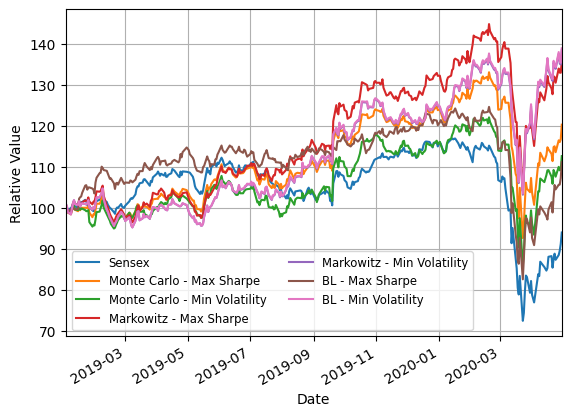

In [0]:
# Plot Aggregate Relative Value Graph

plt.style.use('default')
portfolio_performance.plot(grid=True)
plt.ylabel("Relative Value")
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='best', fontsize='small', ncol=2)
plt.show()

In [0]:
# CAGR
diff = investment_end - investment_date
print((((portfolio_performance.tail(1)/100) ** (365/diff.days)) - 1)*100)

In [0]:
# MDD
print(((portfolio_performance/portfolio_performance.cummax())-1).cummin().min()*-100)